In [18]:
import os
import copy
import glob
import torch
import random
import numpy as np
from tqdm import tqdm

from det3d import torchie
from det3d.datasets import build_dataloader, build_dataset
from det3d.models import build_detector
from det3d.torchie import Config
from det3d.torchie.apis import (
    batch_processor,
    build_optimizer,
    get_root_logger,
    init_dist,
    set_random_seed,
    train_detector,
)
from det3d.torchie.trainer import get_dist_info, load_checkpoint
from det3d.torchie.trainer.utils import all_gather, synchronize
from tools.demo_utils import visual

# Inference on nuScenes mini dataset

In [2]:
work_dir = 'work_dirs/centerpoint_pillar_pretrain/demo-mini'

cfg = Config.fromfile('configs/nusc/pp/nusc_centerpoint_pp_02voxel_two_pfn_10sweep_mini.py')

model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)
checkpoint = load_checkpoint(model, 'work_dirs/centerpoint_pillar_pretrain/latest.pth', map_location="cpu")
model = model.cuda()
model.eval()

dataset = build_dataset(cfg.data.val)
data_loader = build_dataloader(
    dataset,
    batch_size=1,
    workers_per_gpu=cfg.data.workers_per_gpu,
    dist=False,
    shuffle=False,
)

Use HM Bias:  -2.19
10


In [11]:
points_dict = {}
gt_annos_dict = {}

def convert_box(info):
    boxes =  info["gt_boxes"].astype(np.float32)
    names = info["gt_names"]
    assert len(boxes) == len(names)
    detection = {}
    detection['box3d_lidar'] = boxes
    # dummy value 
    detection['label_preds'] = np.zeros(len(boxes)) 
    detection['scores'] = np.ones(len(boxes))
    return detection
    
for i, data in tqdm(enumerate(dataset), total=len(dataset)):
    token = data['metadata']['token']
    # save points for TensorRT
    data["points"].astype(np.float32).tofile(
        f"tensorrt/data/centerpoint/points/{token}.bin"
    )
    # points_list for visualization
    points = data['points'][:, :3]
    points_dict[token] = points.T
    # gt_annos for visualization
    info = dataset._nusc_infos[i]
    gt_annos_dict[token] = convert_box(info)

100%|██████████| 81/81 [00:06<00:00, 11.66it/s]


In [4]:
detections = {}
token_list = []

for i, data_batch in tqdm(enumerate(data_loader), total=len(data_loader.dataset)):
    with torch.no_grad():
        outputs = batch_processor(
            model, data_batch, train_mode=False, local_rank=0
        )
    for output in outputs:
        token = output["metadata"]["token"]
        token_list.append(token)
        for k, v in output.items():
            if k not in [
                "metadata",
            ]:
                output[k] = v.to(torch.device("cpu"))
        detections.update(
            {token: output,}
        )

100%|██████████| 81/81 [00:08<00:00, 10.03it/s]


cc57c1ea80fe46a7abddfdb15654c872


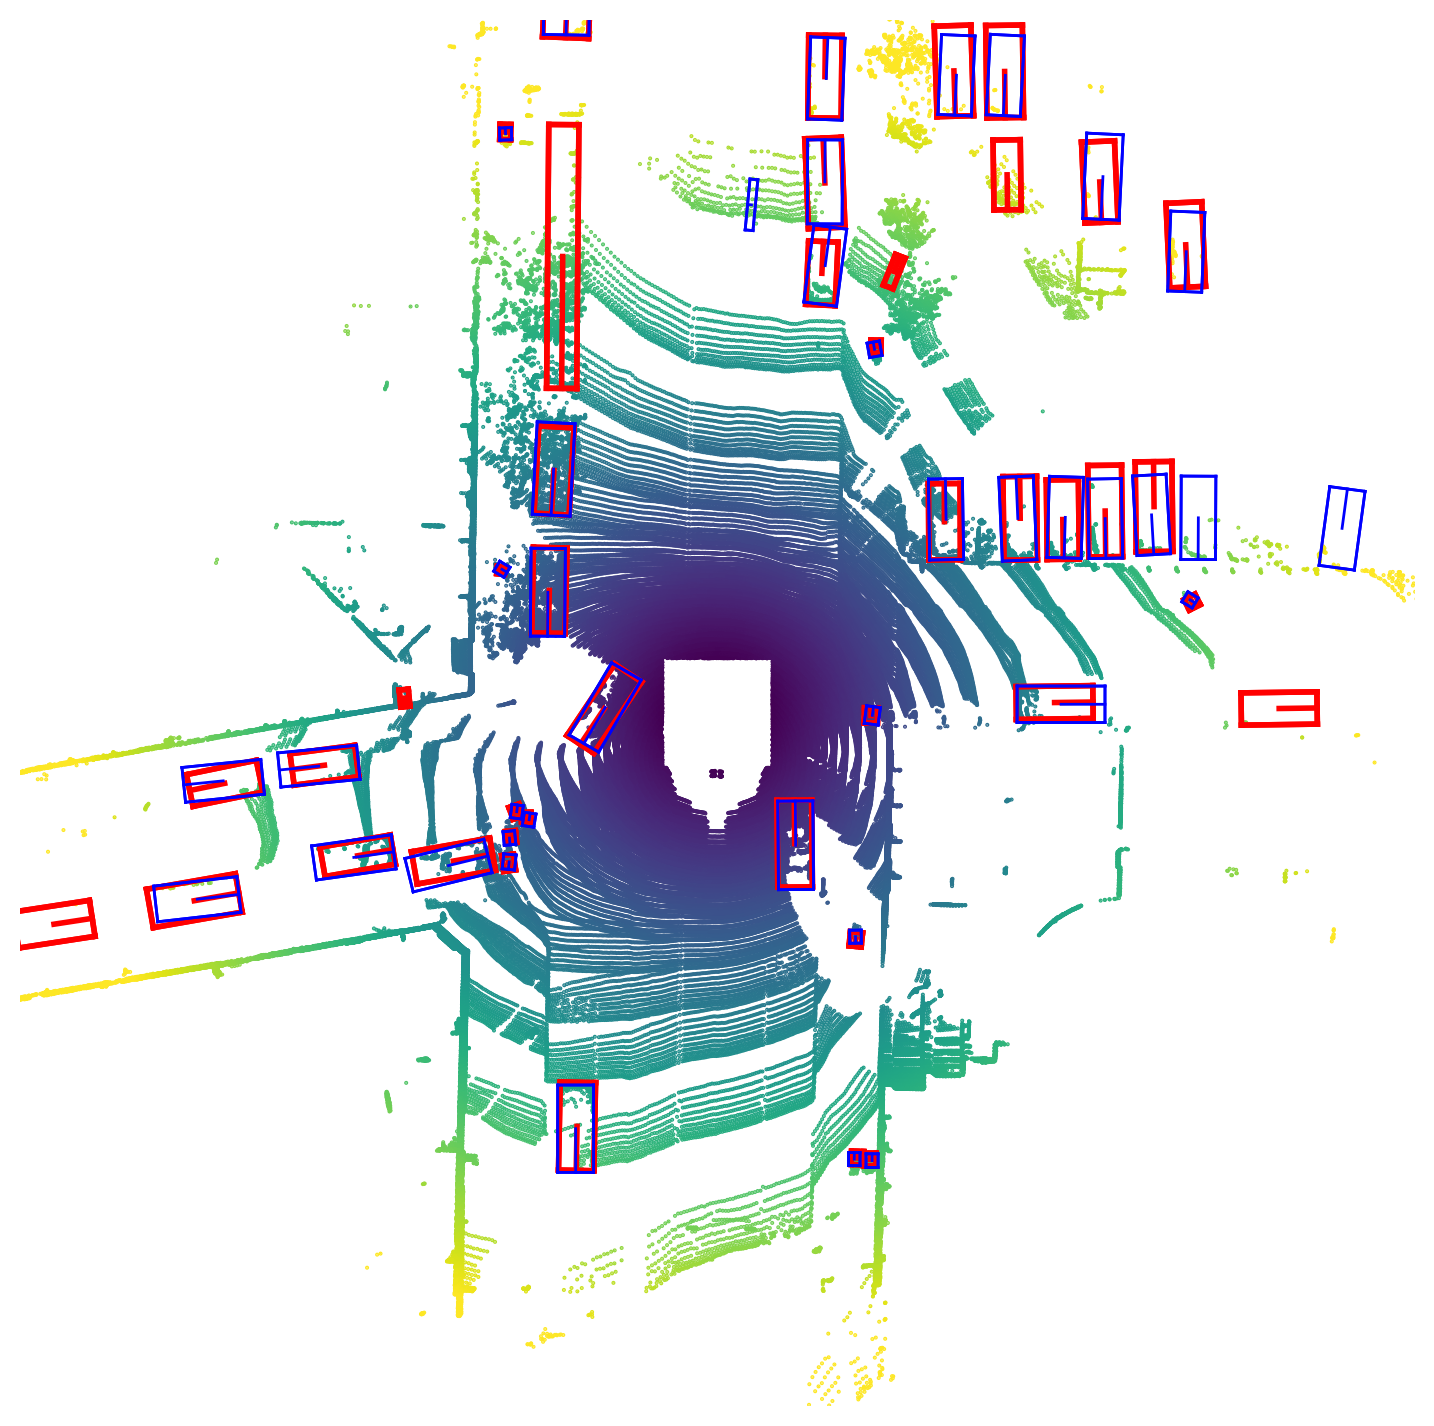

61d9340c5ad8418dafe7a4af1b96e6b9


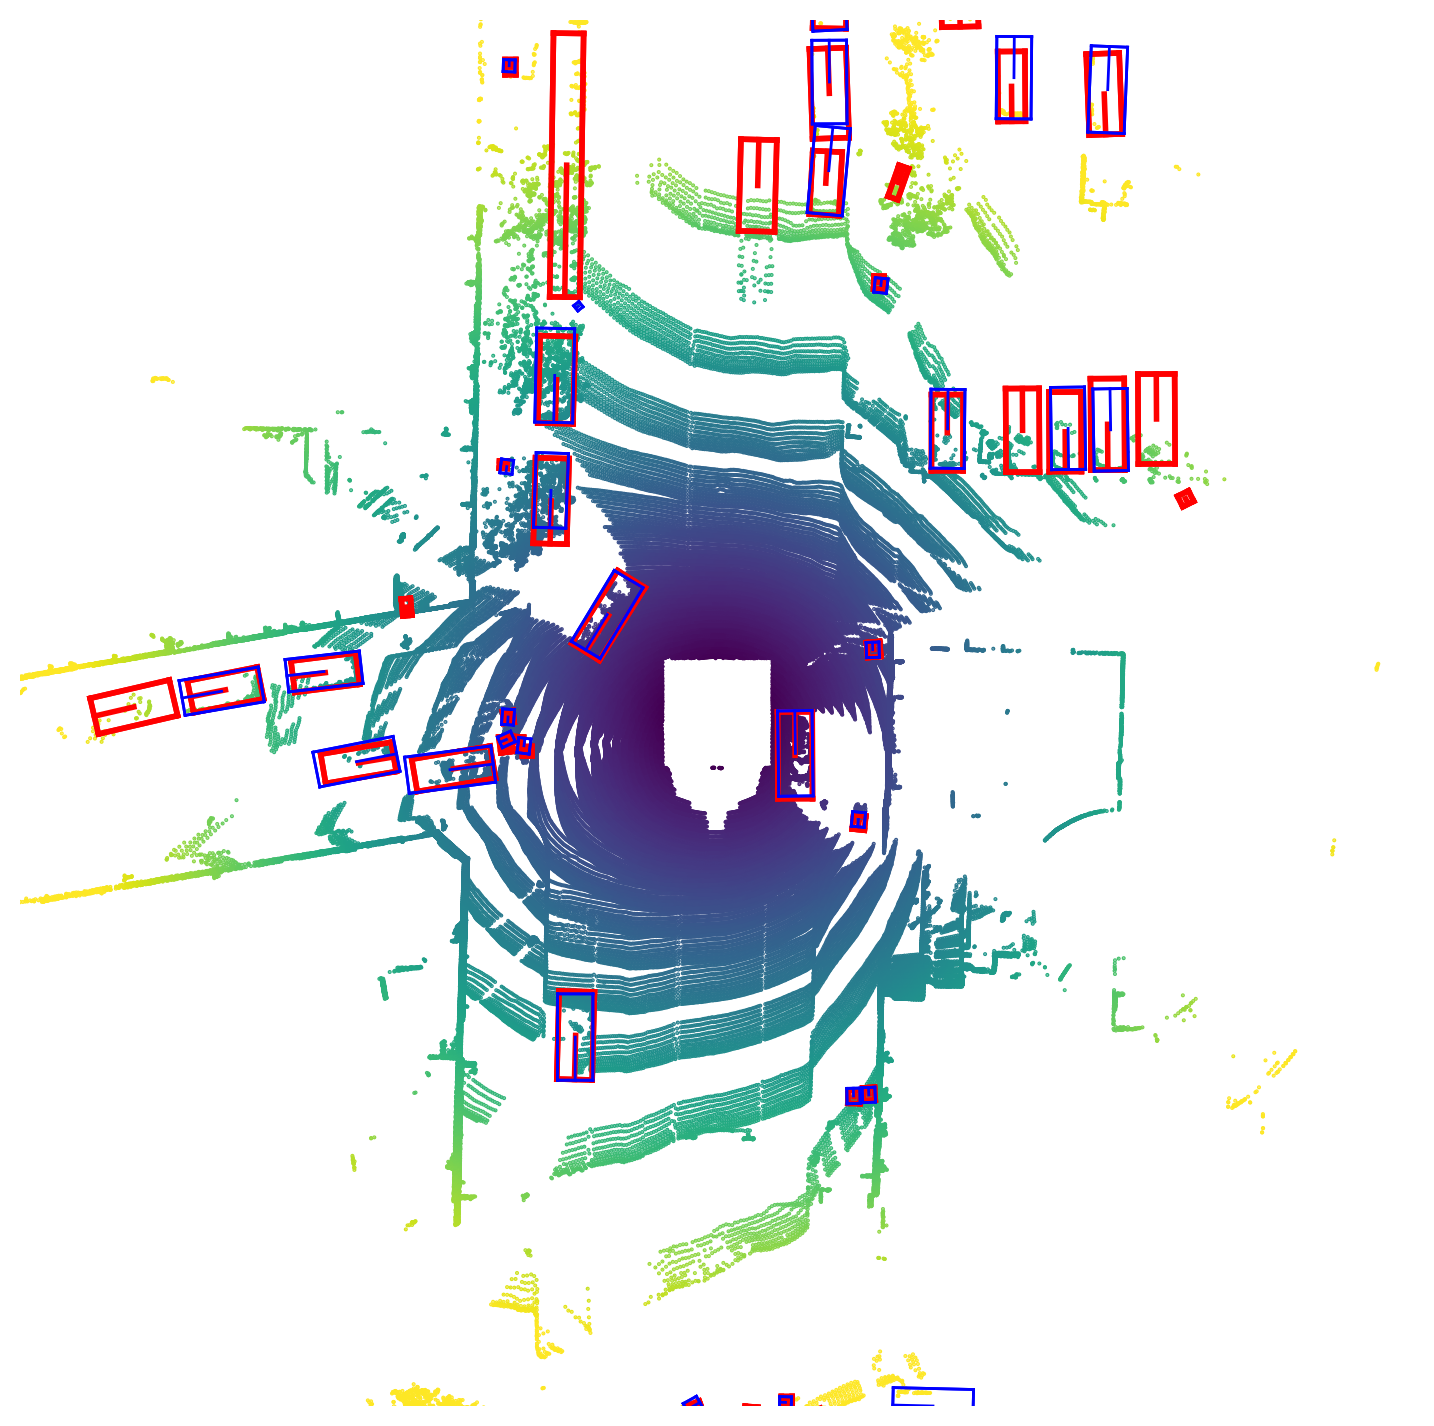

6832e717621341568c759151b5974512


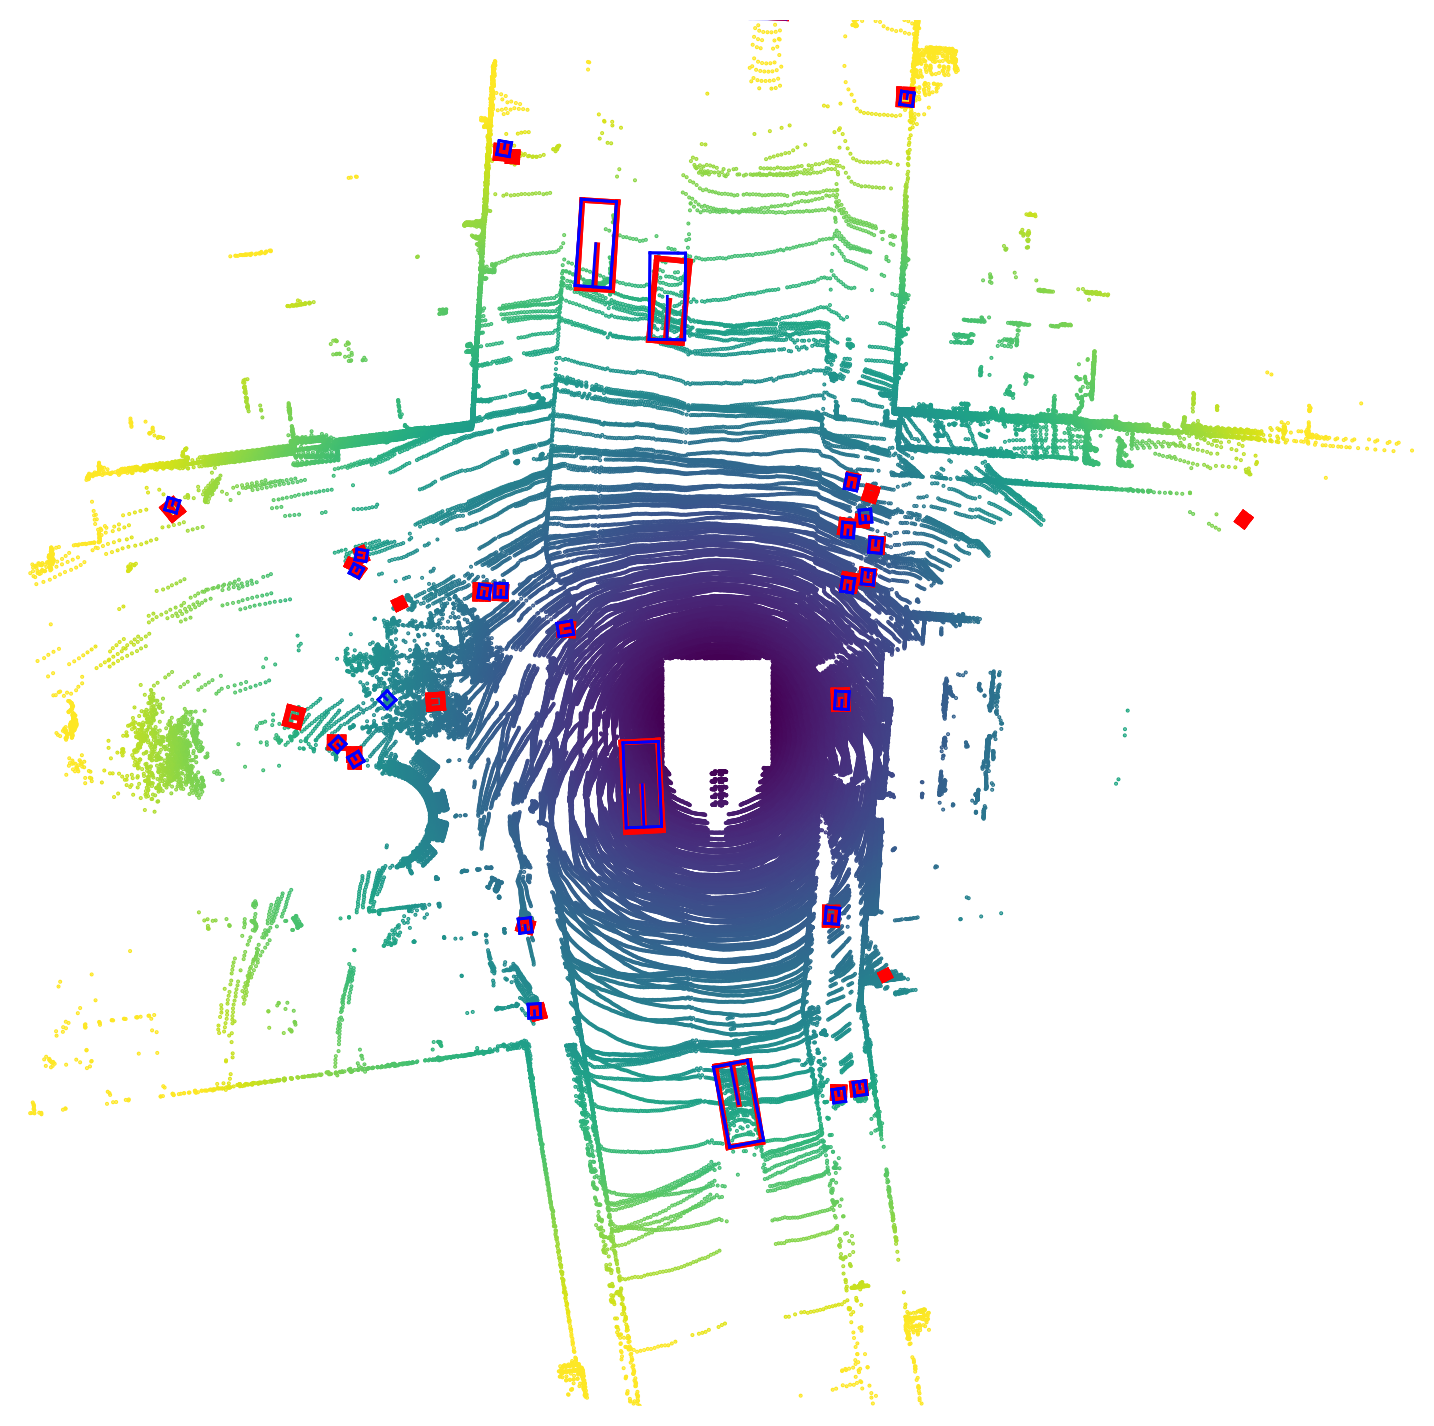

In [19]:
vis_num = 3
draw_num = min(vis_num, len(token_list))
save_path = os.path.join(work_dir, "visual")
for token in random.sample(token_list, draw_num):
    print(token)
    visual(
        points_dict[token], gt_annos_dict[token], detections[token], token, save_path=None
    )

In [ ]:
all_predictions = all_gather(detections)

predictions = {}
for p in all_predictions:
    predictions.update(p)

os.makedirs(work_dir, exist_ok=True)
result_dict, _ = dataset.evaluation(copy.deepcopy(predictions), output_dir=work_dir, testset=False)

if result_dict is not None:
    for k, v in result_dict["results"].items():
        print(f"Evaluation {k}: {v}")

# Evaluete TensorRT results

In [14]:
res_path_list = glob.glob("tensorrt/data/centerpoint/results/*.txt")
trt_work_dir = os.path.join(work_dir, 'tensorrt')

token_list = []
detections = {}

def read_trt_result(path):
    trt_pred = {}
    token = path.split("/")[-1].split(".")[0]

    box3d = []
    score = []
    cls = []
    with open(path) as f:
        trt_res = f.readlines()
    for line in trt_res:
        box3d += [np.array([float(it) for it in line.strip().split(" ")[:9]])]
        score += [np.array([float(line.strip().split(" ")[-2])])]
        cls += [np.array([int(line.strip().split(" ")[-1])])]

    trt_pred["box3d_lidar"] = torch.from_numpy(np.array(box3d))
    trt_pred["scores"] = torch.from_numpy(np.array(score))
    trt_pred["label_preds"] = torch.from_numpy(np.array(cls,np.int32))
    trt_pred["metadata"] = {}
    trt_pred["metadata"]["num_point_features"] = 5
    trt_pred["metadata"]["token"] = token
    
    return trt_pred, token

for path in tqdm(res_path_list):
    output, token = read_trt_result(path)
    token_list.append(token)
    for k, v in output.items():
        if k not in [
            "metadata",
        ]:
            output[k] = v
    detections.update(
        {token: output,}
    )

100%|██████████| 81/81 [00:00<00:00, 601.58it/s]


858a1ece22cf45d9bc71e42336604b78


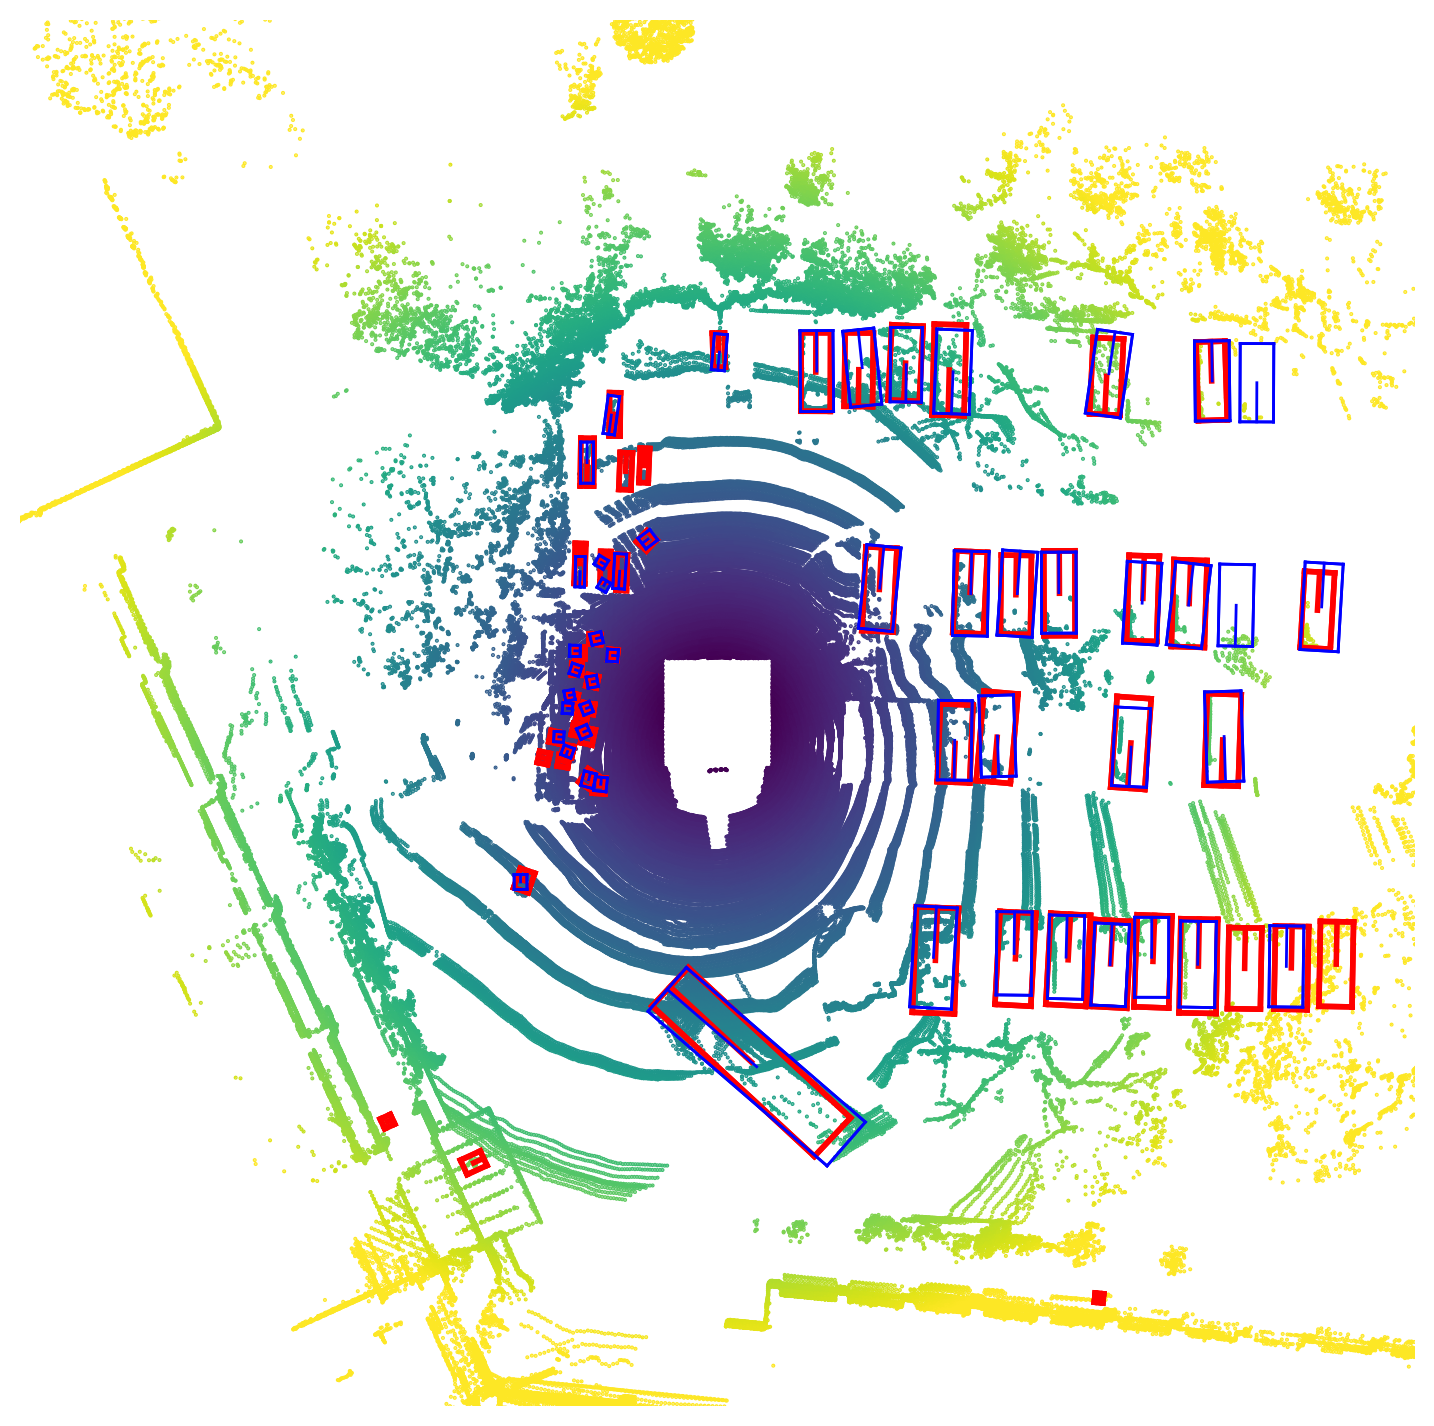

b9ea04a6121d4a8bb00199b885aa5ef0


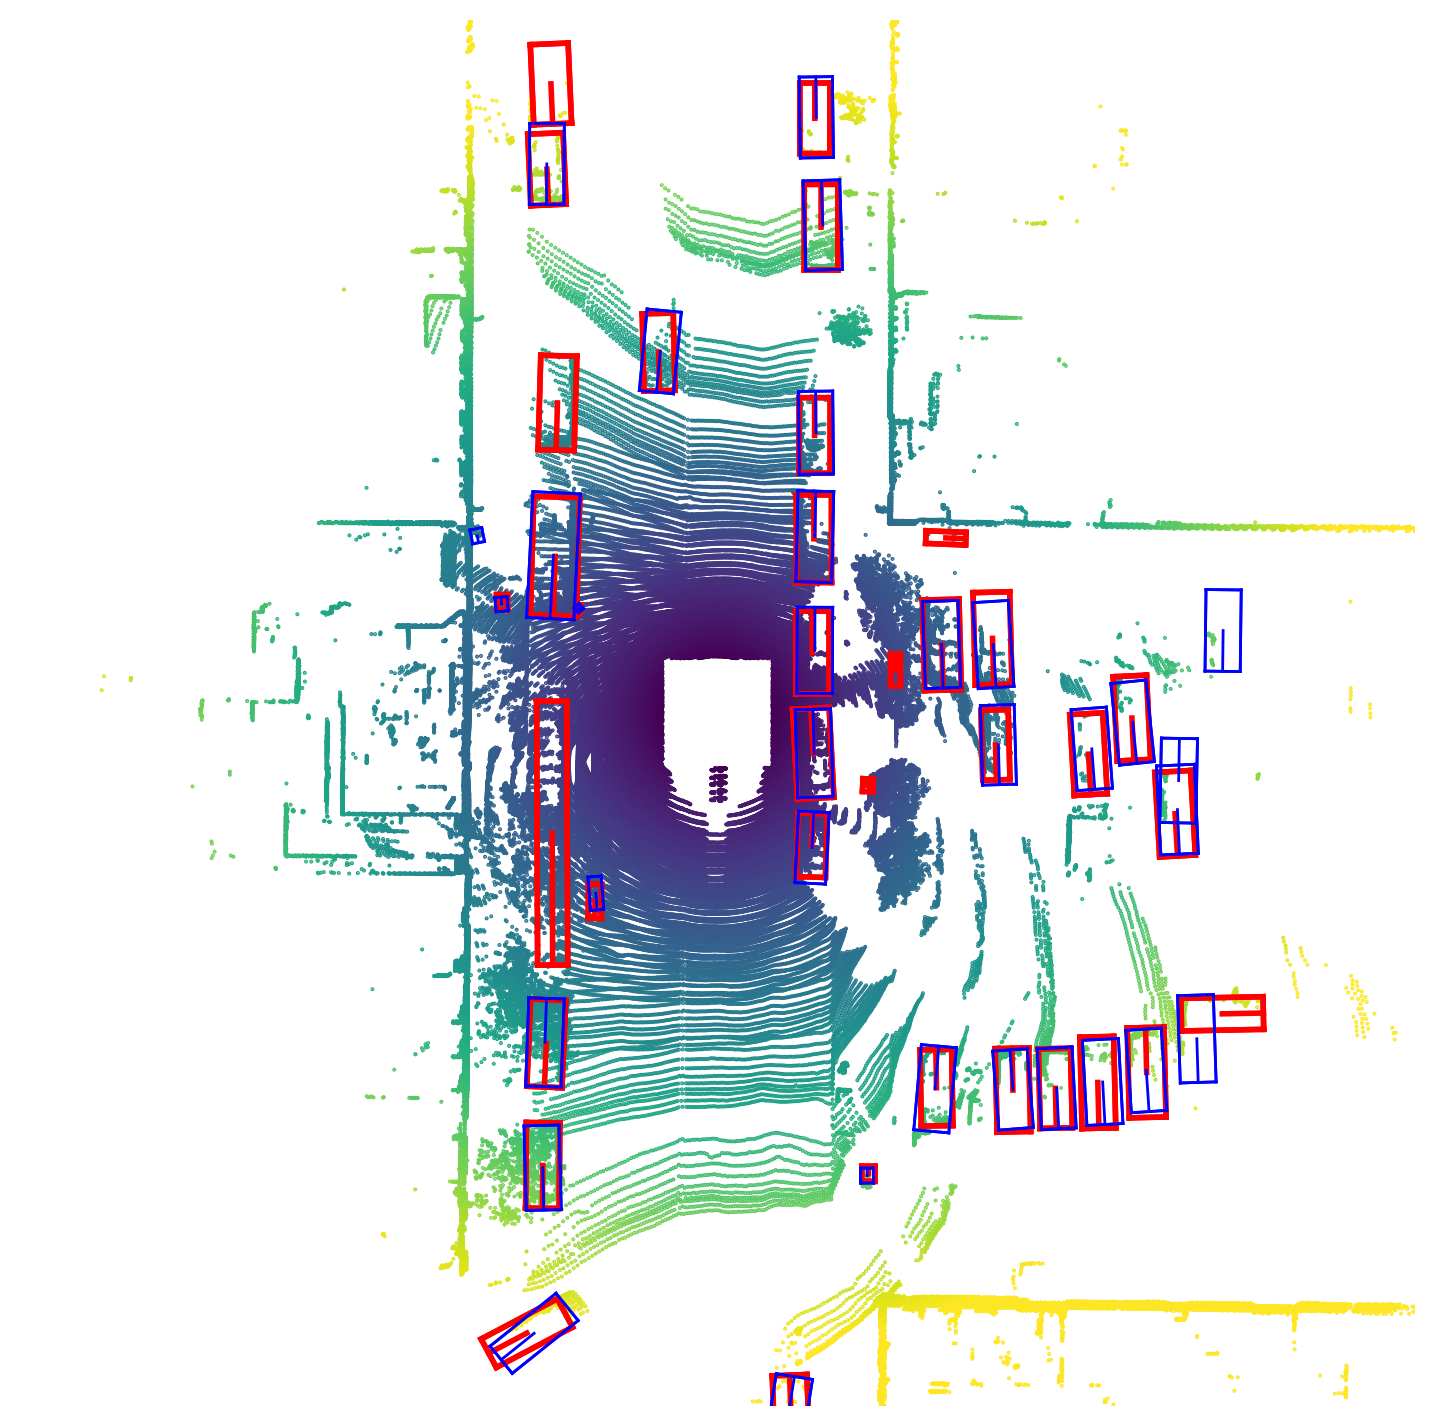

700c1a25559b4433be532de3475e58a9


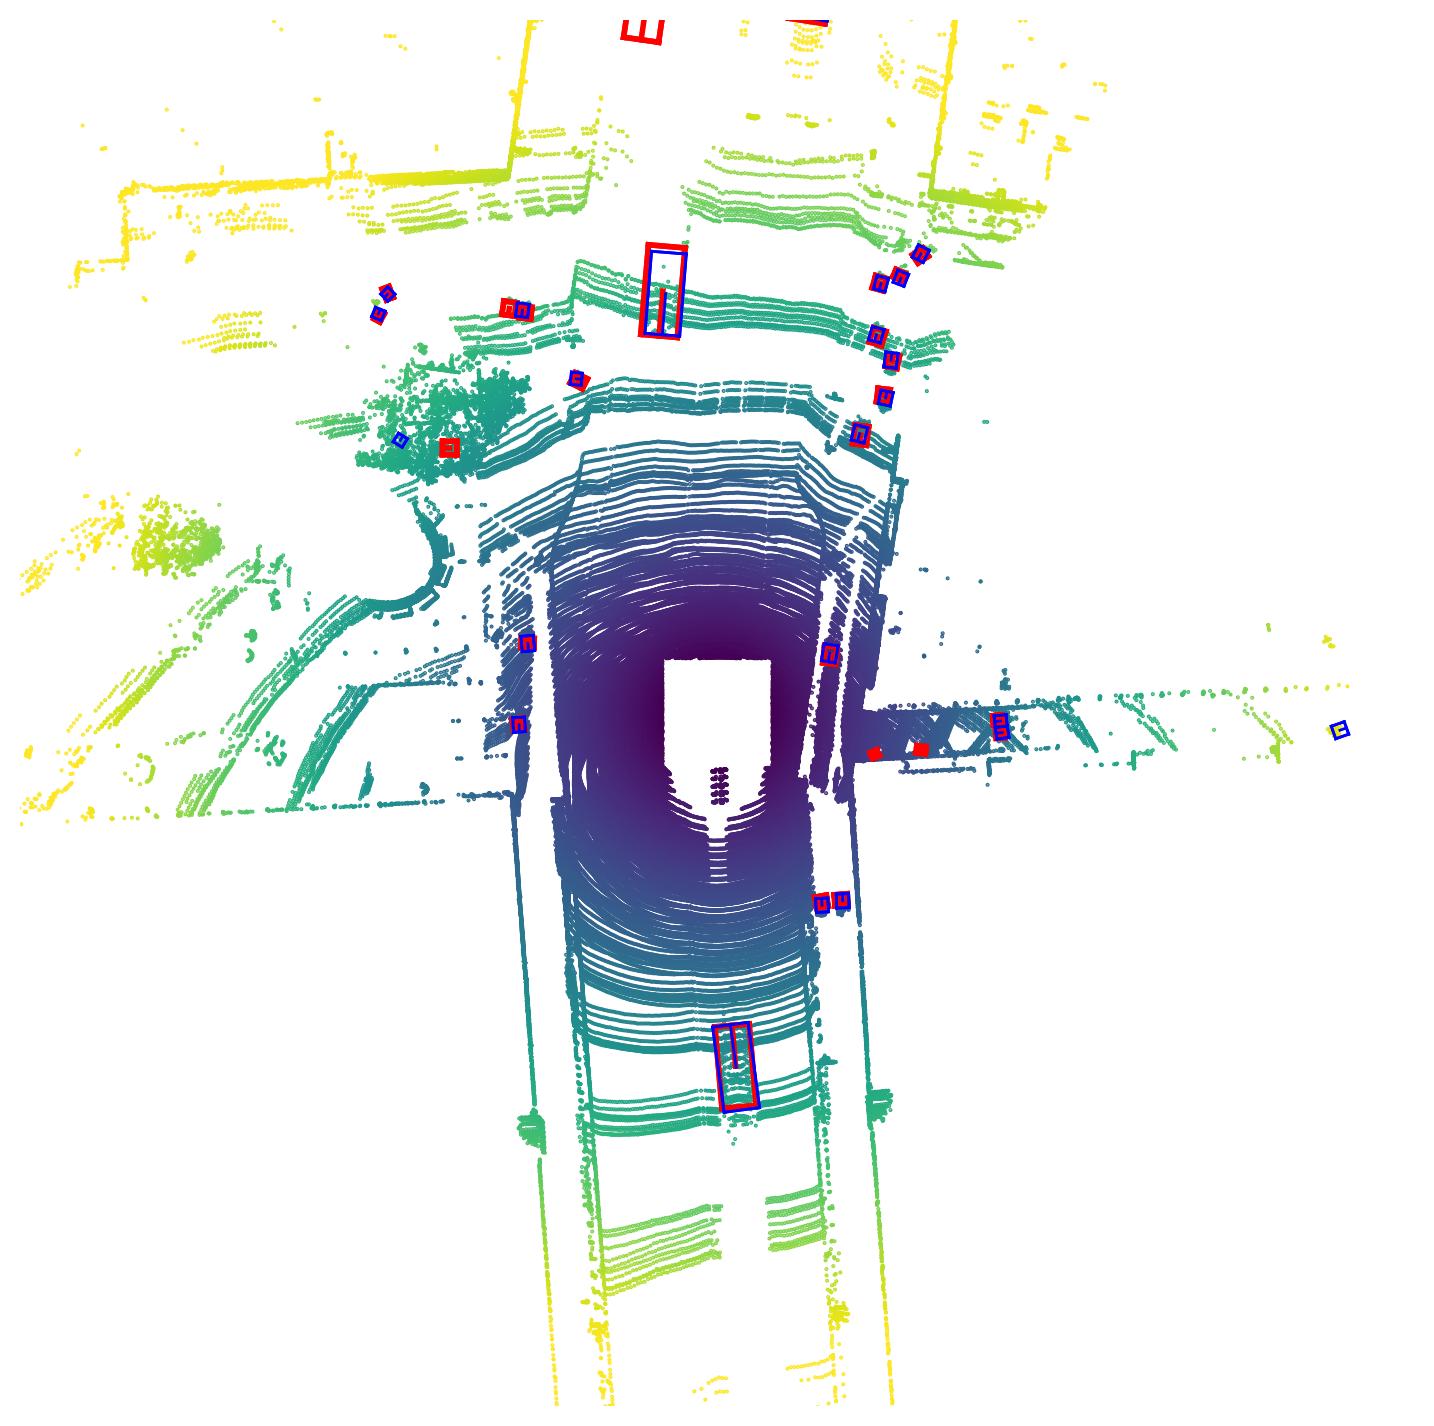

In [20]:
vis_num = 3
draw_num = min(vis_num, len(token_list))
save_path = os.path.join(trt_work_dir, "visual")
for token in random.sample(token_list, draw_num):
    print(token)
    visual(
        points_dict[token], gt_annos_dict[token], detections[token], token, save_path=None
    )

In [21]:
all_predictions = all_gather(detections)

predictions = {}
for p in all_predictions:
    predictions.update(p)

os.makedirs(trt_work_dir, exist_ok=True)
result_dict, _ = dataset.evaluation(copy.deepcopy(predictions), output_dir=trt_work_dir, testset=False)

if result_dict is not None:
    for k, v in result_dict["results"].items():
        print(f"Evaluation {k}: {v}")

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.5 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Finish generate predictions for testset, save to work_dirs/centerpoint_pillar_pretrain/demo-mini/tensorrt/infos_val_10sweeps_withvelo_filter_True.json
Initializing nuScenes detection evaluation
Loaded results from work_dirs/centerpoint_pillar_pretrain/demo-mini/tensorrt/infos_val_10sweeps_withvelo_filter_True.json. Found detections for 81 samples.
Loading annotations for mini_val split from nuScenes version: v1.0-mini


100%|██████████| 81/81 [00:00<00:00, 318.67it/s]


Loaded ground truth annotations for 81 samples.
Filtering predictions
=> Original number of boxes: 15807
=> After distance based filtering: 12876
=> After LIDAR points based filtering: 12876
=> After bike rack filtering: 12813
Filtering ground truth annotations
=> Original number of boxes: 4441
=> After distance based filtering: 3785
=> After LIDAR points based filtering: 3393
=> After bike rack filtering: 3393
Rendering sample token b6c420c3a5bd4a219b1cb82ee5ea0aa7
Rendering sample token b22fa0b3c34f47b6a360b60f35d5d567
Rendering sample token d8251bbc2105497ab8ec80827d4429aa
Rendering sample token 372725a4b00e49c78d6d0b1c4a38b6e0
Rendering sample token ce94ef7a0522468e81c0e2b3a2f1e12d
Rendering sample token 0d0700a2284e477db876c3ee1d864668
Rendering sample token 61a7bd24f88a46c2963280d8b13ac675
Rendering sample token fa65a298c01f44e7a182bbf9e5fe3697
Rendering sample token 8573a885a7cb41d185c05029eeb9a54e
Rendering sample token 38a28a3aaf2647f2a8c0e90e31267bf8
Accumulating metric data.